# Clustering The A Matrix

## Setup

### Import Required Packages

In [4]:
from collections import Counter
from itertools import groupby
import operator
import sys
sys.path.append('../')

from icaviz.plotting import *

import matplotlib.lines as mlines
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.base import clone
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, silhouette_score, pairwise_distances
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid')

DATA_DIR = '../data/precise2_data/'
GENE_DIR = '../data/annotation/'

### Load ICA Data

In [5]:
component_info_df = pd.read_csv(DATA_DIR + 'component_info.csv', index_col=0)
precise2 = load_data(X=DATA_DIR+'log_tpm_qc.csv',
                     S=DATA_DIR+'S.csv',
                     A=DATA_DIR+'A.csv',
                     metadata=DATA_DIR+'metadata_qc.csv',
                     annotation=GENE_DIR+'gene_info.csv',
                     trn=GENE_DIR+'TRN.csv',
                     cutoff = 525, names=component_info_df['name']) # Get correct cut-off score from 3_estimate_thresholds

../icaviz/load.py:350: UserWarning: Genes missing annotations: b0012, b0056, b0057, b4726, b4727, b4728, b4710, b4709, b4729, b0282, b4730, b0322, b4731, b4732, b0470_1, b0470_2, b0470_3, b0484_1, b0484_2, b0484_3, b0502, b4733, b0562, b4734, b4581, b4735, b4736, b4723, b4737, b4490, b1142, b1149, b4738, b4739, b4491, b4521, b4740, b1228, b4573, b4711, b4741, b4742, b1318, b4524, b4743, b4744, b4493, b4745, b1459, b1470, b1471, b4746, b4747, b1506, b4696, b1543, b4748, b4749, b4724, b4750, b4534, b4494, b4751, b4752, b4495, b4496, b2092, b2115, b2139, b4604, b4605, b4725, b2641, b4644, b2649, b2681, b4610, b2850, b2854, b2855, b2858, b2862, b4753, b4754, b2941, b4658, b4755, b3036, b4756, b3268, b3423, b4612, b4660, b4615, b3643, b3681, b3682, b4757, b4488, b3777, b3782, b3808, b4038, b4583, b4223, b4575, b4308, b4720, b4721, b4722, b4715, b4584
  warnings.warn('Genes missing annotations: {}'.format(missing_genes))


### Clustering Helper Function

In [8]:
def cluster_A(A_df, corr_metric='pearson', show_thresholding=False, show_clustermap=True, threshold=None):

    corr_df = A_df.T.corr(method=corr_metric)
    dist_matrix = 1 - corr_df.abs()

    agg_cluster_base = AgglomerativeClustering(
        n_clusters=None,
        affinity='precomputed',
        compute_full_tree=True,
        linkage='complete',
        distance_threshold=0.5
    )
    
    if threshold is None:

        cluster_df = pd.DataFrame(columns=['threshold', 'silhouette', 'n_clusters'])

        dist_thresholds = np.arange(0.15, 1, 0.01)
        cluster_df['threshold'] = dist_thresholds

        for row in cluster_df.itertuples(index=True):
            agg_cluster = clone(agg_cluster_base).set_params(distance_threshold=row.threshold)
            agg_cluster.fit(dist_matrix)
            # compute silhouette score
            sil_score = silhouette_score(dist_matrix, agg_cluster.labels_, metric='precomputed')
            cluster_df.loc[row.Index, 'silhouette'] = sil_score
            cluster_df.loc[row.Index, 'n_clusters'] = agg_cluster.n_clusters_

        best_thresh = cluster_df.sort_values(by='silhouette', ascending=False).iloc[0]['threshold']

        if show_thresholding:
            _, ax = plt.subplots()
            ax.yaxis.grid(False)
            sns.scatterplot(x='threshold', y='silhouette', data=cluster_df, ax=ax, color='blue')
            ax.axvline(best_thresh, linestyle='--', color='k')
            ax.tick_params(axis='both', labelsize=13)
            ax.tick_params(axis='y', color='blue', labelcolor='blue')
            ax.set_xlabel('Threshold', fontsize=14)
            ax.set_ylabel('Silhouette', color='blue', fontsize=14)
            ax2 = ax.twinx()
            ax2.yaxis.grid(False)
            sns.scatterplot(x='threshold', y='n_clusters', data=cluster_df, ax=ax2, color='red')
            ax2.tick_params(axis='both', labelsize=13)
            ax2.tick_params(axis='y', color='red', labelcolor='red')
            ax2.set_ylabel('# Clusters', fontsize=14, color='red')
            plt.show()
            
    else:
        best_thresh = threshold

    # re-perform the clustering with the best parameters
    agg_cluster_best = clone(agg_cluster_base).set_params(distance_threshold=best_thresh)
    agg_cluster_best.fit(dist_matrix)
    
    labels = agg_cluster_best.labels_
        
    if show_clustermap or show_imodulon_clusters:
        # Children of hierarchical clustering
        children = agg_cluster_best.children_

        # Distances between each pair of children
        # Since we don't have this information, we can use a uniform one for plotting
        distance = np.arange(children.shape[0])

        # The number of observations contained in each cluster level
        no_of_observations = np.arange(2, children.shape[0]+2)

        # Create linkage matrix and then plot the dendrogram
        linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
        
        cluster_size_dict = Counter(labels)
        
        if show_clustermap:
            g = sns.clustermap(
                corr_df,
                figsize=(10, 10), 
                row_linkage=linkage_matrix,
                col_linkage=linkage_matrix,
                xticklabels=False,
                center=0
            )
            g.ax_heatmap.set_yticks(np.arange(0.5, A_df.shape[0] + 0.5, 1))
            reord_ind = g.dendrogram_row.reordered_ind
            g.ax_heatmap.set_yticklabels(
                np.array(corr_df.index)[np.array(reord_ind)],
                fontsize=8
            )
            
            size_counter = 1
            first_i = 0
            for i, ind in enumerate(reord_ind):
                ind_cluster = agg_cluster_best.labels_[ind]
                cluster_size = cluster_size_dict[ind_cluster]
                if cluster_size == size_counter:
                    g.ax_heatmap.add_patch(
                        Rectangle((first_i, first_i), cluster_size, cluster_size, fill=False, color='white')
                    )
                    g.ax_heatmap.add_line(
                        mlines.Line2D(
                            [corr_df.shape[0], corr_df.shape[0]+10],
                            [i+1, i+1],
                            color='black',
                            linewidth=0.5,
                            clip_on=False
                        )
                    )
                    size_counter = 1
                    first_i = i+1
                else:
                    size_counter += 1
            plt.show()

    return agg_cluster_best

## Hierarchical Clustering

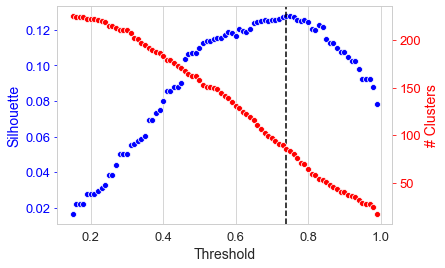

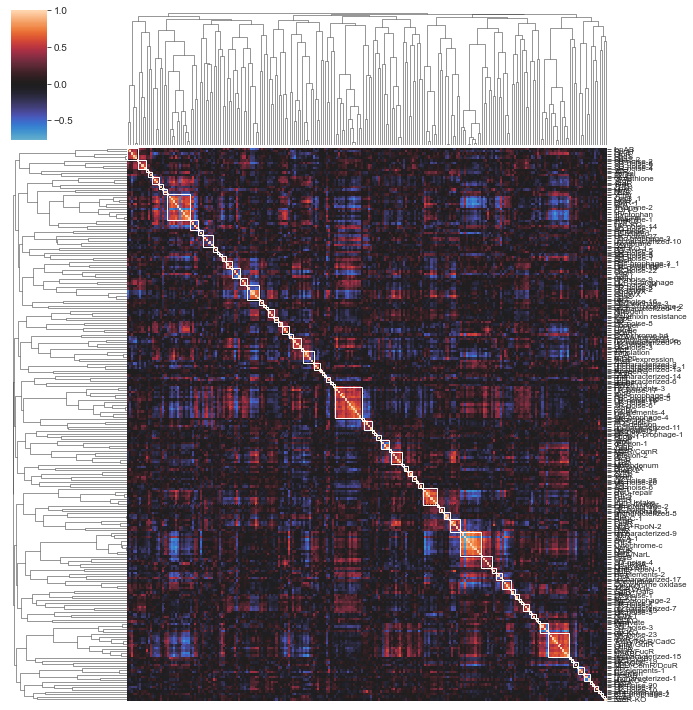

AgglomerativeClustering(affinity='precomputed', compute_full_tree=True,
                        distance_threshold=0.7400000000000005,
                        linkage='complete', n_clusters=None)

In [10]:
cluster_A(precise2.A, show_thresholding=True)